In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [9]:
n_samples = 4
n_length = 300

x_batch = np.random.normal(size=(n_samples, n_length)).astype(np.float32)
y_batch = np.zeros((n_samples, n_length)).astype(np.int32)
for i in range(n_samples):
    start = np.random.choice(n_length // 2)
    end = start + np.random.choice(n_length // 2)
    if i < n_samples//2:
        y_batch[i, start:end+1] = 1

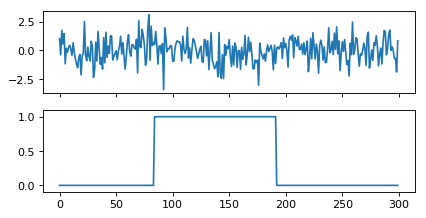

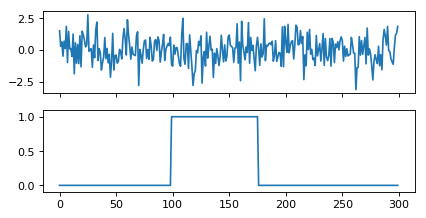

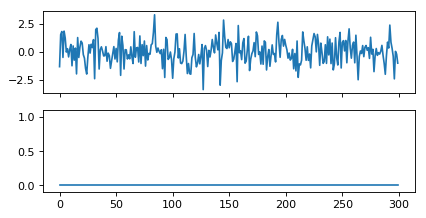

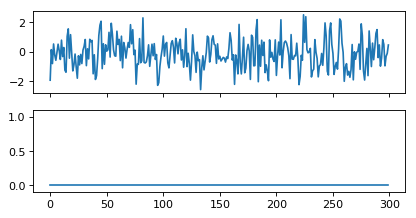

In [10]:
for i in range(n_samples):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 3), dpi=80)
    ax[0].plot(x_batch[i, ...])
    ax[1].plot(y_batch[i, ...])
    ax[1].set_ylim([-0.1, 1.1])
    plt.show()


In [25]:
tf.reset_default_graph()
inputs = tf.placeholder(shape=[None, n_length], dtype=tf.float32)
labels = tf.placeholder(shape=[None, n_length], dtype=tf.int32)

outputs = inputs - 1

# weight_negative = 0.5
# weight_positive = 2.0
# class_weights = tf.stack([weight_negative, weight_positive], axis=0)
# weights = tf.gather(class_weights, y)

labels_2d = tf.expand_dims(tf.cast(labels, tf.float32), 1)
labels_2d = tf.expand_dims(labels_2d, 3)
spread_labels = tf.nn.conv2d(labels_2d, filter=np.ones((1, 9, 1, 1)), strides=[1, 1, 1, 1], padding='SAME')
spread_labels = tf.squeeze(spread_labels, [1, 3])
spread_labels = tf.cast(tf.math.greater(spread_labels, 0), tf.float32)

n_negative = tf.cast(tf.reduce_sum(1 - labels), tf.float32)
n_positive = tf.cast(tf.reduce_sum(labels), tf.float32)
n_negative_already_added = tf.reduce_sum(spread_labels) - n_positive
n_negative_to_add = tf.nn.relu(n_positive - n_negative_already_added)

p_keep_negative = n_negative_to_add / (n_negative + 1e-3)  # in (0, 1)
p_drop_negative = 1 - p_keep_negative
random_mask = tf.random.uniform(
    tf.shape(outputs),
    minval=0.0,
    maxval=1.0,
    dtype=tf.float32)
random_mask = random_mask + spread_labels
binarized_mask = tf.cast(tf.math.greater(random_mask, p_drop_negative), tf.float32)

loss_per_sample = binarized_mask

# loss_per_sample = out ** 2 * weights
total_loss = tf.reduce_sum(loss_per_sample) / n_length

sess = tf.Session()
tf.global_variables_initializer()

<tf.Operation 'init' type=NoOp>

Positive loss 185.0
Negative loss 187.0


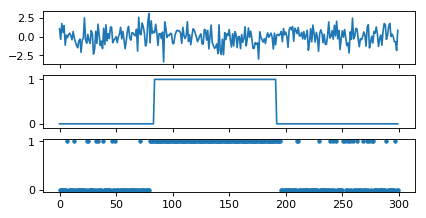

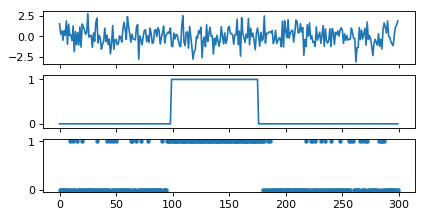

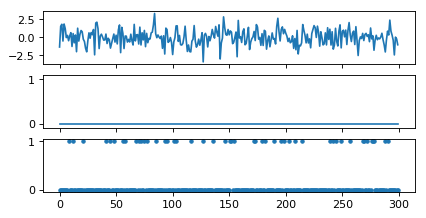

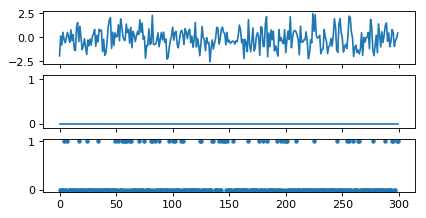

In [34]:
np_loss_per_sample = sess.run(loss_per_sample, feed_dict={labels: y_batch, inputs: x_batch})

print('Positive loss', np.sum(np_loss_per_sample * y_batch))
print('Negative loss', np.sum(np_loss_per_sample * (1-y_batch)))


for i in range(n_samples):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(6, 3), dpi=80)
    ax[0].plot(x_batch[i, ...])
    ax[1].plot(y_batch[i, ...])
    ax[1].set_ylim([-0.1, 1.1])
    ax[2].plot(np_loss_per_sample[i, ...], '.')
    plt.show()

185.0

In [18]:
np.sum(np_loss_per_sample * (1-y_batch))

216.0